In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import torchaudio

random.seed(0)
np.random.seed(0)

In [2]:
!nvidia-smi

Tue Aug  1 22:13:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P0             149W / 350W |    457MiB / 24576MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust          664
fear             705
joy            19002
neutral        14429
sadness         2936
surprise        5062

In [6]:
anger = go_emotions[go_emotions["grouped_label"] == "anger"].sample(5000, replace=False, random_state=0)
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True, random_state=0)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True, random_state=0)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False, random_state=0)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(5000, replace=False, random_state=0)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True, random_state=0)

In [7]:
go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, anger, disgust, fear, joy, neutral, sadness])
go_emotions.groupby("grouped_label").count()

text
grouped_label      
anger          5000
disgust        4664
fear           4705
joy            5000
neutral        5000
sadness        4936
surprise       5062

In [8]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [9]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [10]:
pd.concat([train_audio,test_audio]).groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise   592

In [11]:
audio_datasets = pd.concat([train_audio,test_audio]).reset_index(drop=True)

In [12]:
surprise = audio_datasets[audio_datasets["label"] == "surprise"].sample(2000, replace=True, random_state=0)
audio_datasets = audio_datasets[audio_datasets["label"] != "surprise"]
audio_datasets = pd.concat([audio_datasets, surprise]).reset_index(drop=True)
#audio_datasets

In [13]:
audio_datasets.groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise  2000

## Load Meld and IEMOCAP

In [14]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

text     label  \
0      [BFRS] The only one I know still love his pare...       joy   
1      [BFRS] Yeah, that kind of went out of style di...   neutral   
2      [BFRS] You know it's nice here, the air is swe...       joy   
3      [BFRS] You're not sorry you came? [BFRE] Not s...   sadness   
4      [BFRS] Not sorry, no.  I can't stay here. [BFR...   sadness   
...                                                  ...       ...   
13723  [BFRS] Come on. It doesn't taste bad. [BFRE] Y...   neutral   
13724  [BFRS] Yeah, it's kinda sweet, sorta like, uh....       joy   
13725  [BFRS] Cantaloupe juice. [BFRE] Exactly. [AFTS...   neutral   
13726  [BFRS] Exactly. [BFRE] You've tasted it? You'v...  surprise   
13727  [BFRS] You've tasted it? You've tasted it. [BF...   neutral   

       num_tokens                                               path  
0              15  /home/vmachado/Documents/multimodal-datasets/I...  
1              13  /home/vmachado/Documents/multimodal-datasets/I...  
2               9  /home/vmachado/Documents/multimodal-datasets/I...  
3              14  /home/vmachado/Documents/multimodal-datasets/I...  
4               5  /home/vmachado/Documents/multimodal-datasets/I...  
...           ...                                                ...  
13723          15  /home/vmachado/Documents/multimodal-datasets/M...  
13724           9  /home/vmachado/Documents/multimodal-datasets/M...  
13725           4  /home/vmachado/Documents/multimodal-datasets/M...  
13726          12  /home/vmachado/Documents/multimodal-datasets/M...  
13727           5  /home/vmachado/Documents/multimodal-datasets/M...  

[13728 rows x 4 columns]

In [15]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

text    label  num_tokens  \
0     [BFRS]  [BFRE] Brian, I need help. [AFTS] Babe...  sadness           8   
1     [BFRS] Brian, I need help. [BFRE] Babe, I don'...  neutral          20   
2     [BFRS] I don't--I'm just--I'm thinking maybe I...  neutral          34   
3     [BFRS] How did you get a job?  What am I - Wha...  neutral          19   
4     [BFRS] I mean, I just don't--I don't know.  If...  neutral           6   
...                                                 ...      ...         ...   
3846  [BFRS] It isn't. [BFRE] It is. [AFTS] Isn't! [...  neutral           5   
3847         [BFRS] It is. [BFRE] Isn't! [AFTS]  [AFTE]    anger           5   
3848  [BFRS]  [BFRE] Yeah baby! [AFTS] I’m really gl...      joy           5   
3849  [BFRS] Yeah baby! [BFRE] I’m really glad you g...  neutral          32   
3850                   [BFRS] [BFRE] Hey. [AFTS] [AFTE]  neutral           4   

                                                   path  
0     /home/vmachado/Documents/multimodal-datasets/I...  
1     /home/vmachado/Documents/multimodal-datasets/I...  
2     /home/vmachado/Documents/multimodal-datasets/I...  
3     /home/vmachado/Documents/multimodal-datasets/I...  
4     /home/vmachado/Documents/multimodal-datasets/I...  
...                                                 ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...  
3847  /home/vmachado/Documents/multimodal-datasets/M...  
3848  /home/vmachado/Documents/multimodal-datasets/M...  
3849  /home/vmachado/Documents/multimodal-datasets/M...  
3850  /home/vmachado/Documents/multimodal-datasets/M...  

[3851 rows x 4 columns]

In [16]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

text    label  num_tokens  \
0     [BFRS]  [BFRE] Brian, I need help. [AFTS] Babe...  sadness           8   
1     [BFRS] Brian, I need help. [BFRE] Babe, I don'...  neutral          20   
2     [BFRS] I don't--I'm just--I'm thinking maybe I...  neutral          34   
3     [BFRS] How did you get a job?  What am I - Wha...  neutral          19   
4     [BFRS] I mean, I just don't--I don't know.  If...  neutral           6   
...                                                 ...      ...         ...   
3846  [BFRS] It isn't. [BFRE] It is. [AFTS] Isn't! [...  neutral           5   
3847         [BFRS] It is. [BFRE] Isn't! [AFTS]  [AFTE]    anger           5   
3848  [BFRS]  [BFRE] Yeah baby! [AFTS] I’m really gl...      joy           5   
3849  [BFRS] Yeah baby! [BFRE] I’m really glad you g...  neutral          32   
3850                   [BFRS] [BFRE] Hey. [AFTS] [AFTE]  neutral           4   

                                                   path   source  
0     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
1     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
2     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
3     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
4     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
...                                                 ...      ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3847  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3848  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3849  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3850  /home/vmachado/Documents/multimodal-datasets/M...     meld  

[3851 rows x 5 columns]

In [17]:
test_df_erc.groupby("source").count()

text  label  num_tokens  path
source                                
iemocap  1241   1241        1241  1241
meld     2610   2610        2610  2610

## Join datasets

In [18]:
train_df_erc.groupby("label").count()

text  num_tokens  path
label                           
anger     1954        1954  1954
disgust    258         258   258
fear       266         266   266
joy       2783        2783  2783
neutral   5804        5804  5804
sadness   1451        1451  1451
surprise  1212        1212  1212

In [19]:
ang = train_df_erc[train_df_erc["label"] == "anger"].sample(3000, replace=True, random_state=0)
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(4700, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(4700, replace=True, random_state=0)
joy = train_df_erc[train_df_erc["label"] == "joy"].sample(2300, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(3500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(3800, replace=True, random_state=0)

#excited = train_df_erc[train_df_erc["label"] == "excited"].sample(4300, replace=True, random_state=0)
#frustration = train_df_erc[train_df_erc["label"] == "frustration"].sample(3600, replace=True, random_state=0)

In [20]:
#train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness, excited, frustration]).reset_index(drop=True)
train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness]).reset_index(drop=True)

In [21]:
#train_df_erc_resampled = train_df_erc

In [22]:
train_df_erc_resampled.groupby("label").count()

text  num_tokens  path
label                           
anger     4954        4954  4954
disgust   4958        4958  4958
fear      4966        4966  4966
joy       5083        5083  5083
neutral   5804        5804  5804
sadness   4951        4951  4951
surprise  5012        5012  5012

## VoxPopuli + VoxCeleb

In [23]:
df_vox = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]]
df_vox

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

In [24]:
df_ls = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]] #pd.read_csv("df_ls.csv")
df_ls

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

## Join all datasets

In [25]:
#df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
#df_train = pd.concat([audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled,train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), train_df_erc_resampled, df_ls, audio_datasets]).reset_index(drop=True)
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
90346                                                NaN  surprise   
90347                                                NaN  surprise   
90348                                                NaN  surprise   
90349                                                NaN  surprise   
90350                                                NaN  surprise   

                                                 path  num_tokens  \
0                                                None         NaN   
1                                                None         NaN   
2                                                None         NaN   
3                                                None         NaN   
4                                                None         NaN   
...                                               ...         ...   
90346  ./audio/audio_emo/tess.woman.surprised.351.wav         NaN   
90347   ./audio/audio_emo/ravdass.man.surprise.63.wav         NaN   
90348   ./audio/audio_emo/tess.woman.surprised.26.wav         NaN   
90349   ./audio/audio_emo/tess.woman.surprised.67.wav         NaN   
90350   ./audio/audio_emo/ravdass.man.surprise.52.wav         NaN   

      sentiment_label  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
90346             NaN  
90347             NaN  
90348             NaN  
90349             NaN  
90350             NaN  

[90351 rows x 5 columns]

In [26]:
import math

def label_to_sentiment(x):
    if x == None:
        return x
    if x in ["joy", "surprise", "excited"]:
        return "Positive"
    elif x in ["fear", "anger", "disgust", "sadness", "frustration"]:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_train["sentiment_label"] = df_train["label"].apply(label_to_sentiment)

In [28]:
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
90346                                                NaN  surprise   
90347                                                NaN  surprise   
90348                                                NaN  surprise   
90349                                                NaN  surprise   
90350                                                NaN  surprise   

                                                 path  num_tokens  \
0                                                None         NaN   
1                                                None         NaN   
2                                                None         NaN   
3                                                None         NaN   
4                                                None         NaN   
...                                               ...         ...   
90346  ./audio/audio_emo/tess.woman.surprised.351.wav         NaN   
90347   ./audio/audio_emo/ravdass.man.surprise.63.wav         NaN   
90348   ./audio/audio_emo/tess.woman.surprised.26.wav         NaN   
90349   ./audio/audio_emo/tess.woman.surprised.67.wav         NaN   
90350   ./audio/audio_emo/ravdass.man.surprise.52.wav         NaN   

      sentiment_label  
0            Negative  
1            Positive  
2            Positive  
3            Positive  
4            Positive  
...               ...  
90346        Positive  
90347        Positive  
90348        Positive  
90349        Positive  
90350        Positive  

[90351 rows x 5 columns]

In [29]:
df_train["sentiment_label"].value_counts()

Negative    46586
Positive    24212
Neutral     19553
Name: sentiment_label, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train['label'].unique())

lab_encoder_senti = LabelEncoder()
lab_encoder_senti.fit(df_train['sentiment_label'].unique())

LabelEncoder()

In [31]:
len(df_train)

90351

In [32]:
len(test_df_erc)

3851

In [33]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [34]:
gc.collect()

0

In [35]:
import numpy as np
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [36]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

global PREVIOUS_LR
PREVIOUS_LR = -9999
def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    global PREVIOUS_LR
    lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
    #return lr
    if lr <= 3e-4:
        PREVIOUS_LR = lr
        return lr
    else:
        #lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        while lr >= PREVIOUS_LR:
            step += 1.
            lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        PREVIOUS_LR = lr
        return lr

In [37]:
from src.modeling.speech_encoder import *

dim_embed = 768
N_VECTORS = 128
MAX_LEN = 48

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=6, 
    max_length=MAX_LEN, 
    nheads=6,
    dropout=0.2
)

#audio_encoder = torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_best/audio_encoder.bin')
#audio_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_pre_trained_reformed_5_FIM_6_layer_continue/audio_best.bin'))

In [38]:
from src.modeling.text_encoder import *

#MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
#MODEL_NAME = 'sentence-transformers/all-MiniLM-L12-v2'
#text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]'])
#text_encoder.load_state_dict(torch.load('/home/vmachado/Documents/c4ai_clip_audio_text/text_encoder_only_meld/dabest_text.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/best_text_encoder.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/pytorch_model_AudioTextCLIP_epoch_22.bin'))

In [39]:
#for param in list(text_encoder.parameters()):
#    param.requires_grad = True
    
#for idx_l, l in enumerate(text_encoder.encoder.encoder.layer):
#    if idx_l >= 11:
#        for param in list(l.parameters()):
#            param.requires_grad = True

In [40]:
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
90346                                                NaN  surprise   
90347                                                NaN  surprise   
90348                                                NaN  surprise   
90349                                                NaN  surprise   
90350                                                NaN  surprise   

                                                 path  num_tokens  \
0                                                None         NaN   
1                                                None         NaN   
2                                                None         NaN   
3                                                None         NaN   
4                                                None         NaN   
...                                               ...         ...   
90346  ./audio/audio_emo/tess.woman.surprised.351.wav         NaN   
90347   ./audio/audio_emo/ravdass.man.surprise.63.wav         NaN   
90348   ./audio/audio_emo/tess.woman.surprised.26.wav         NaN   
90349   ./audio/audio_emo/tess.woman.surprised.67.wav         NaN   
90350   ./audio/audio_emo/ravdass.man.surprise.52.wav         NaN   

      sentiment_label  
0            Negative  
1            Positive  
2            Positive  
3            Positive  
4            Positive  
...               ...  
90346        Positive  
90347        Positive  
90348        Positive  
90349        Positive  
90350        Positive  

[90351 rows x 5 columns]

In [41]:
list(df_train[~df_train["path"].isna()]["path"])

['/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M000.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F003.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M002.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F004.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F005.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F

In [42]:
from src.utils.speech_processing import *
from tqdm import tqdm
audio_tokenizer = AudioEncoderMFCCHUTokenizer(max_length=MAX_LEN, cache_path='/home/vmachado/Documents/c4ai_clip_audio_text/speech_features_500ms/')
#_, lens = audio_tokenizer.cache_dataset(paths=list(df_train[~df_train["path"].isna()].sample(frac=0.25, random_state=0)["path"]))


In [43]:
"""
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2048, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

mean = None
std = None

for e in range(10):
    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if len(batch_indices[0]) < 2048:
            continue
        batch = df_train.iloc[batch_indices[0]]
        x, lens = audio_tokenizer.cache_dataset(paths=list(batch[~batch["path"].isna()]["path"]))
        if i == 0 and e == 0:
            mean = x.mean(dim=0)
            std = x.std(dim=0)
        else:
            mean_bfr = mean
            mean = 0.9 * mean + 0.1 * x.mean(dim=0)
            print(np.abs(mean - mean_bfr).sum())
            std = 0.9 * std + 0.1 * x.std(dim=0)
    
"""

'\ntrain_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))\ntrain_loader = torch.utils.data.DataLoader(train_ds, batch_size=2048, shuffle=True)\n\ntest_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))\ntest_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)\n\nmean = None\nstd = None\n\nfor e in range(10):\n    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):\n        if len(batch_indices[0]) < 2048:\n            continue\n        batch = df_train.iloc[batch_indices[0]]\n        x, lens = audio_tokenizer.cache_dataset(paths=list(batch[~batch["path"].isna()]["path"]))\n        if i == 0 and e == 0:\n            mean = x.mean(dim=0)\n            std = x.std(dim=0)\n        else:\n            mean_bfr = mean\n            mean = 0.9 * mean + 0.1 * x.mean(dim=0)\n            print(np.abs(mean - mean_bfr).sum())\n            std = 0.9 * std + 0.1 * x.std(dim=0)\n    \n'

In [44]:
mean = torch.tensor([-7.4700e+02,  6.1580e+00, -1.6141e+02,  2.4464e+01, -1.7640e+02,
        -5.8843e+01, -1.9218e+02, -7.5818e+01, -1.2378e+02, -3.6036e+01,
        -1.0406e+02, -2.7860e+01, -7.1468e+01,  2.2020e-01,  3.1072e-01,
         2.7268e-01,  2.3750e-01,  1.9707e-01,  1.7588e-01,  1.5647e-01,
         1.4560e-01,  1.3006e-01,  1.1757e-01,  1.0836e-01,  1.0262e-01,
         9.1613e-02,  8.5846e-02,  7.9762e-02,  7.5073e-02,  6.8178e-02,
         6.3719e-02,  5.7517e-02,  5.4928e-02,  4.9925e-02,  4.6512e-02,
         4.2386e-02,  4.0530e-02,  3.7059e-02,  3.5215e-02,  3.2874e-02,
         3.1318e-02,  2.8704e-02,  2.7749e-02,  2.5589e-02,  2.4804e-02,
         2.3095e-02,  2.2166e-02,  2.0681e-02,  1.9675e-02,  1.8028e-02,
         1.7254e-02,  1.6333e-02,  1.5475e-02,  1.4134e-02,  1.3550e-02,
         1.2394e-02,  1.1780e-02,  1.1379e-02,  1.0363e-02,  9.8019e-03,
         9.4517e-03,  8.8021e-03,  8.2274e-03,  8.0172e-03,  7.7313e-03,
         7.3124e-03,  6.8777e-03,  6.4692e-03,  6.1699e-03,  5.9353e-03,
         5.6277e-03,  5.4599e-03,  5.2376e-03,  4.9934e-03,  4.7451e-03,
         4.5114e-03,  4.3172e-03,  4.2379e-03,  3.9843e-03,  3.8193e-03,
         3.5915e-03,  3.4402e-03,  3.1817e-03,  3.0798e-03,  2.8537e-03,
         2.6614e-03,  2.4821e-03,  2.4174e-03,  2.2813e-03,  2.1782e-03,
         2.0620e-03,  1.9078e-03,  1.8193e-03,  1.7113e-03,  1.6223e-03,
         1.4856e-03,  1.4610e-03,  1.3854e-03,  1.2805e-03,  1.2149e-03,
         1.1226e-03,  1.0761e-03,  1.0318e-03,  9.6978e-04,  9.2847e-04,
         8.4673e-04,  8.1996e-04,  7.7595e-04,  7.5833e-04,  6.9319e-04,
         6.6422e-04,  6.0265e-04,  5.7160e-04,  5.5084e-04,  5.1743e-04,
         4.7284e-04,  4.4492e-04,  4.2051e-04,  3.5157e-04,  3.4111e-04,
         2.9675e-04,  2.5798e-04,  2.5515e-04,  2.2124e-04,  1.9507e-04,
         1.6708e-04,  1.4647e-04,  1.1749e-04,  2.5000e+00,  1.1531e+00,
        -1.2263e+00,  4.1787e-01, -9.8134e-01, -2.9367e-01, -1.2589e+00,
        -2.1857e-01, -7.5790e-01, -2.2440e-01, -8.5317e-01, -2.4389e-01,
        -5.7301e-01,  4.1964e-03,  5.1526e-03,  4.5006e-03,  3.9765e-03,
         3.1733e-03,  2.6975e-03,  2.3247e-03,  2.1174e-03,  1.8767e-03,
         1.8053e-03,  1.5541e-03,  1.4890e-03,  1.3441e-03,  1.2698e-03,
         1.1844e-03,  1.2161e-03,  1.0952e-03,  9.3636e-04,  9.2067e-04,
         8.8425e-04,  8.0866e-04,  7.5633e-04,  7.4324e-04,  6.5902e-04,
         6.6421e-04,  5.5818e-04,  5.7753e-04,  5.7934e-04,  5.3377e-04,
         4.9429e-04,  4.4782e-04,  4.5718e-04,  3.9794e-04,  3.8491e-04,
         3.8266e-04,  3.7828e-04,  3.2701e-04,  3.1301e-04,  2.9994e-04,
         3.0148e-04,  2.6907e-04,  2.6756e-04,  2.2407e-04,  2.3762e-04,
         2.1063e-04,  2.0321e-04,  2.0983e-04,  1.7550e-04,  1.8518e-04,
         1.8342e-04,  1.7226e-04,  1.7882e-04,  1.6266e-04,  1.4215e-04,
         1.2648e-04,  1.3957e-04,  1.2112e-04,  1.3272e-04,  1.1470e-04,
         1.1536e-04,  1.0373e-04,  1.0308e-04,  9.5482e-05,  8.8373e-05,
         8.2384e-05,  8.1976e-05,  7.8339e-05,  8.3171e-05,  7.5021e-05,
         5.8356e-05,  5.8757e-05,  5.2301e-05,  4.6326e-05,  4.1214e-05,
         3.9770e-05,  3.6737e-05,  3.6990e-05,  3.4389e-05,  3.0950e-05,
         2.6084e-05,  2.7930e-05,  2.6482e-05,  2.5583e-05,  2.7505e-05,
         2.4227e-05,  2.3010e-05,  1.9177e-05,  1.9447e-05,  1.8802e-05,
         1.8523e-05,  1.6991e-05,  1.6829e-05,  1.3990e-05,  1.5298e-05,
         1.5116e-05,  1.4909e-05,  1.3739e-05,  1.4740e-05,  1.1900e-05,
         1.0273e-05,  1.2616e-05,  9.3498e-06,  9.2379e-06,  1.0415e-05,
         7.6029e-06,  6.2445e-06,  7.4380e-06,  5.3918e-06,  5.0714e-06,
         3.9498e-06,  4.3060e-06,  3.8587e-06,  4.0841e-06,  3.1611e-06,
         3.4743e-06, -2.8973e+00, -1.7951e-01,  8.8920e-01,  1.5124e-01,
         7.7084e-01,  5.9045e-01,  8.1344e-01,  4.8235e-01,  7.8571e-01,
         3.5225e-01,  4.3522e-01,  2.3837e-01,  3.6900e-01, -1.8200e-03,
        -2.4973e-03, -2.2480e-03, -1.8840e-03, -1.6223e-03, -1.4397e-03,
        -1.2795e-03, -1.1567e-03, -1.0585e-03, -8.9726e-04, -8.5220e-04,
        -7.8401e-04, -7.1794e-04, -6.4949e-04, -5.7546e-04, -5.4204e-04,
        -4.7930e-04, -5.3218e-04, -4.5095e-04, -4.5656e-04, -4.1567e-04,
        -3.7963e-04, -3.3524e-04, -3.4786e-04, -2.5529e-04, -2.7408e-04,
        -2.4645e-04, -2.2103e-04, -2.0722e-04, -1.8750e-04, -1.8925e-04,
        -1.7059e-04, -1.6526e-04, -1.4312e-04, -1.2484e-04, -1.1870e-04,
        -1.2002e-04, -1.0639e-04, -1.0813e-04, -9.1822e-05, -7.5492e-05,
        -8.1647e-05, -8.1812e-05, -7.1175e-05, -7.2098e-05, -6.3533e-05,
        -5.0927e-05, -5.7496e-05, -4.3992e-05, -4.5578e-05, -4.6068e-05,
        -4.1929e-05, -3.9203e-05, -4.3368e-05, -4.7600e-05, -3.7310e-05,
        -4.3906e-05, -3.7452e-05, -4.5748e-05, -3.8661e-05, -4.8188e-05,
        -4.3857e-05, -4.1807e-05, -3.9804e-05, -4.0027e-05, -3.6022e-05,
        -3.1982e-05, -3.1068e-05, -3.3237e-05, -3.2235e-05, -2.8048e-05,
        -2.6033e-05, -2.7119e-05, -2.5346e-05, -2.3976e-05, -2.4364e-05,
        -2.2480e-05, -2.0588e-05, -2.2478e-05, -2.1009e-05, -2.0617e-05,
        -2.1423e-05, -1.6923e-05, -1.8635e-05, -1.8514e-05, -2.0261e-05,
        -2.0572e-05, -1.5696e-05, -1.4800e-05, -1.4128e-05, -1.4376e-05,
        -1.3266e-05, -1.2543e-05, -1.2952e-05, -1.2325e-05, -1.2550e-05,
        -1.1974e-05, -1.0018e-05, -9.7020e-06, -1.0221e-05, -9.3304e-06,
        -8.5663e-06, -9.5051e-06, -6.2807e-06, -7.8799e-06, -6.0285e-06,
        -5.2378e-06, -3.7896e-06, -2.9819e-06, -4.0475e-06, -4.1311e-06,
        -2.6668e-06, -1.8387e-06, -2.1641e-06, -1.4746e-06],
       dtype=torch.float64)

In [45]:
std = torch.tensor([3.4861e+02, 1.8644e+02, 2.1335e+02, 1.9020e+02, 1.7906e+02, 1.7233e+02,
        1.6325e+02, 1.5760e+02, 1.5113e+02, 1.5170e+02, 1.3350e+02, 1.2769e+02,
        1.1588e+02, 9.8106e-01, 1.4069e+00, 1.3138e+00, 1.1409e+00, 9.8407e-01,
        9.4065e-01, 8.5272e-01, 7.7581e-01, 6.7397e-01, 6.0602e-01, 5.9308e-01,
        5.7790e-01, 4.8153e-01, 4.7516e-01, 4.1881e-01, 4.0686e-01, 3.7195e-01,
        3.4382e-01, 3.1547e-01, 3.0531e-01, 2.9186e-01, 2.6723e-01, 2.3582e-01,
        2.5691e-01, 2.2171e-01, 2.3015e-01, 2.1749e-01, 2.0711e-01, 1.9125e-01,
        2.1207e-01, 1.8324e-01, 1.7451e-01, 1.6873e-01, 1.7826e-01, 1.6191e-01,
        1.6531e-01, 1.5013e-01, 1.4397e-01, 1.4363e-01, 1.3901e-01, 1.3876e-01,
        1.2938e-01, 1.1880e-01, 1.2116e-01, 1.2508e-01, 1.0947e-01, 1.0112e-01,
        1.0773e-01, 1.0094e-01, 9.0657e-02, 9.6119e-02, 9.0879e-02, 9.1453e-02,
        8.1072e-02, 7.5991e-02, 7.4476e-02, 7.5844e-02, 7.0705e-02, 7.1825e-02,
        6.8998e-02, 7.2536e-02, 6.8156e-02, 6.3608e-02, 6.2248e-02, 6.4749e-02,
        6.0677e-02, 5.9104e-02, 5.7961e-02, 5.7103e-02, 5.1407e-02, 5.1511e-02,
        4.7575e-02, 4.6827e-02, 4.4988e-02, 4.4817e-02, 4.5540e-02, 4.1954e-02,
        4.0709e-02, 3.8064e-02, 3.8988e-02, 3.7874e-02, 4.0406e-02, 3.3050e-02,
        3.3442e-02, 3.4858e-02, 3.5607e-02, 3.2364e-02, 2.7831e-02, 2.6588e-02,
        2.6458e-02, 2.4490e-02, 2.6877e-02, 2.3441e-02, 2.3533e-02, 2.3232e-02,
        2.6500e-02, 2.1673e-02, 2.1326e-02, 2.0265e-02, 1.8279e-02, 1.8737e-02,
        1.8774e-02, 1.6969e-02, 1.6809e-02, 1.7081e-02, 1.4361e-02, 1.4339e-02,
        1.2817e-02, 1.0886e-02, 1.3157e-02, 1.0641e-02, 9.6336e-03, 8.9547e-03,
        7.5394e-03, 5.9837e-03, 7.9957e+01, 5.5070e+01, 6.0645e+01, 5.7969e+01,
        5.2958e+01, 5.0153e+01, 4.7730e+01, 4.5576e+01, 4.5368e+01, 4.3108e+01,
        3.9769e+01, 3.7046e+01, 3.4927e+01, 2.9543e-01, 4.1743e-01, 3.9851e-01,
        3.5086e-01, 2.9811e-01, 2.8225e-01, 2.5450e-01, 2.3351e-01, 2.0237e-01,
        1.8221e-01, 1.7946e-01, 1.7769e-01, 1.4658e-01, 1.4564e-01, 1.2917e-01,
        1.2375e-01, 1.1421e-01, 1.0471e-01, 9.6454e-02, 9.4739e-02, 9.0654e-02,
        8.3722e-02, 7.3370e-02, 8.0387e-02, 6.9291e-02, 7.1872e-02, 6.7754e-02,
        6.4380e-02, 5.9676e-02, 6.6384e-02, 5.6916e-02, 5.4292e-02, 5.2779e-02,
        5.6282e-02, 5.1082e-02, 5.2210e-02, 4.7221e-02, 4.4993e-02, 4.5178e-02,
        4.4041e-02, 4.3355e-02, 4.0838e-02, 3.7469e-02, 3.7976e-02, 3.9374e-02,
        3.4319e-02, 3.2068e-02, 3.3909e-02, 3.1884e-02, 2.8764e-02, 3.0550e-02,
        2.8704e-02, 2.8986e-02, 2.5788e-02, 2.3879e-02, 2.3394e-02, 2.3633e-02,
        2.2305e-02, 2.2562e-02, 2.1683e-02, 2.2846e-02, 2.1445e-02, 1.9895e-02,
        1.9375e-02, 2.0342e-02, 1.9291e-02, 1.8782e-02, 1.8281e-02, 1.8001e-02,
        1.6365e-02, 1.6428e-02, 1.5100e-02, 1.4857e-02, 1.4256e-02, 1.4209e-02,
        1.4539e-02, 1.3283e-02, 1.2986e-02, 1.2156e-02, 1.2309e-02, 1.2163e-02,
        1.2969e-02, 1.0506e-02, 1.0628e-02, 1.1072e-02, 1.1422e-02, 1.0461e-02,
        8.8366e-03, 8.4295e-03, 8.4420e-03, 7.8026e-03, 8.5983e-03, 7.4519e-03,
        7.5223e-03, 7.4792e-03, 8.5563e-03, 6.9990e-03, 6.8854e-03, 6.5497e-03,
        5.7972e-03, 6.0155e-03, 6.0004e-03, 5.4153e-03, 5.3961e-03, 5.4486e-03,
        4.6473e-03, 4.6297e-03, 4.1344e-03, 3.5140e-03, 4.2492e-03, 3.4199e-03,
        3.0778e-03, 2.9033e-03, 2.4354e-03, 1.9246e-03, 3.2177e+01, 2.4533e+01,
        2.6900e+01, 2.6436e+01, 2.3722e+01, 2.2421e+01, 2.1061e+01, 2.0125e+01,
        2.0118e+01, 1.9214e+01, 1.7641e+01, 1.6410e+01, 1.5515e+01, 1.3079e-01,
        1.8417e-01, 1.7738e-01, 1.5622e-01, 1.3186e-01, 1.2428e-01, 1.1244e-01,
        1.0344e-01, 8.9733e-02, 8.0262e-02, 7.9635e-02, 7.9043e-02, 6.4851e-02,
        6.4418e-02, 5.7440e-02, 5.4697e-02, 5.0351e-02, 4.6213e-02, 4.2461e-02,
        4.2079e-02, 4.0345e-02, 3.7169e-02, 3.2334e-02, 3.5873e-02, 3.0595e-02,
        3.1835e-02, 2.9992e-02, 2.8481e-02, 2.6364e-02, 2.9278e-02, 2.5175e-02,
        2.3971e-02, 2.3351e-02, 2.4809e-02, 2.2624e-02, 2.3106e-02, 2.0900e-02,
        1.9876e-02, 1.9988e-02, 1.9340e-02, 1.9105e-02, 1.7969e-02, 1.6555e-02,
        1.6777e-02, 1.7396e-02, 1.5188e-02, 1.4019e-02, 1.4949e-02, 1.4025e-02,
        1.2558e-02, 1.3371e-02, 1.2567e-02, 1.2701e-02, 1.1410e-02, 1.0538e-02,
        1.0358e-02, 1.0477e-02, 9.8993e-03, 1.0066e-02, 9.6120e-03, 1.0248e-02,
        9.6499e-03, 8.8512e-03, 8.6413e-03, 9.0658e-03, 8.5224e-03, 8.3442e-03,
        8.0568e-03, 7.9644e-03, 7.2975e-03, 7.2940e-03, 6.7146e-03, 6.5947e-03,
        6.3820e-03, 6.3308e-03, 6.4369e-03, 5.9169e-03, 5.7991e-03, 5.3996e-03,
        5.4878e-03, 5.3960e-03, 5.7803e-03, 4.6987e-03, 4.7542e-03, 4.9537e-03,
        5.0997e-03, 4.6633e-03, 3.9597e-03, 3.7809e-03, 3.7697e-03, 3.4828e-03,
        3.8193e-03, 3.3312e-03, 3.3657e-03, 3.3334e-03, 3.8207e-03, 3.1184e-03,
        3.0637e-03, 2.9141e-03, 2.6109e-03, 2.6889e-03, 2.6824e-03, 2.4479e-03,
        2.3969e-03, 2.4474e-03, 2.0506e-03, 2.0608e-03, 1.8264e-03, 1.5471e-03,
        1.8757e-03, 1.5317e-03, 1.3673e-03, 1.2730e-03, 1.0761e-03, 8.5209e-04],
       dtype=torch.float64)

In [46]:
audio_tokenizer.mean = mean
audio_tokenizer.std = std

In [47]:
len(df_train[~df_train["path"].isna()]["path"].unique()) + len(test_df_erc[~test_df_erc["path"].isna()]["path"].unique())

36412

In [48]:
gc.collect()

20

In [49]:
from src.modeling.losses import *

In [50]:
from src.modeling.mm_contrast import *

In [51]:
from tqdm import tqdm

In [52]:
pre_train_text = True
pre_train_audio = False

## Text Pretraining

100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]


General - KNN F1: 0.46862785063926715 Acc: 0.4596208776941054
Iemocap - KNN F1: 0.6303440819640107 Acc: 0.6220789685737309
Meld - KNN F1: 0.397491645003251 Acc: 0.3823754789272031
Iemocap - KNN F1 (macro): 0.3597262476677615
Meld - KNN F1 (macro): 0.3139617772942197


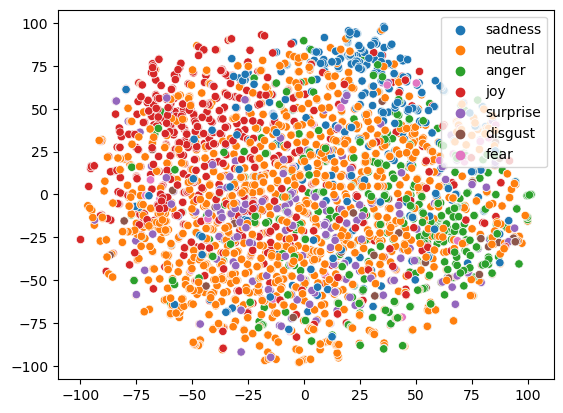

Epoch: 1 - Train Loss: 5.246147547336603


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it]


General - KNN F1: 0.5318312430735018 Acc: 0.5229810438847052
Iemocap - KNN F1: 0.6464563833352112 Acc: 0.6390008058017728
Meld - KNN F1: 0.48224931620974526 Acc: 0.46781609195402296
Iemocap - KNN F1 (macro): 0.3675710249183172
Meld - KNN F1 (macro): 0.3695667274436064


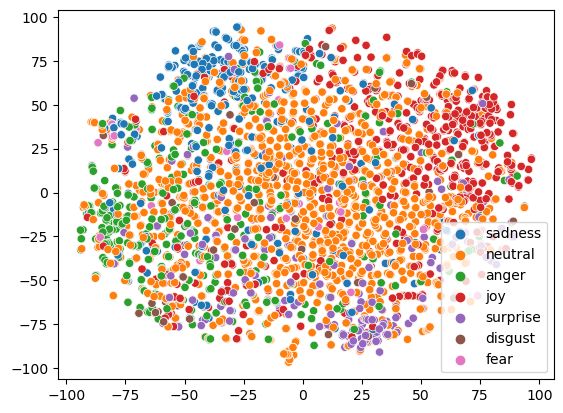

Epoch: 2 - Train Loss: 4.967430536320667


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it]


General - KNN F1: 0.5563228360367499 Acc: 0.5492079979226175
Iemocap - KNN F1: 0.6693616277226065 Acc: 0.6591458501208702
Meld - KNN F1: 0.5058769174217875 Acc: 0.49693486590038316
Iemocap - KNN F1 (macro): 0.3794309321039453
Meld - KNN F1 (macro): 0.3817545101697806


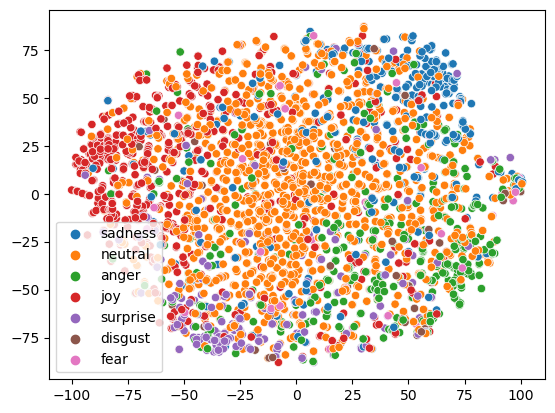

Epoch: 3 - Train Loss: 4.81219400949036


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it]


General - KNN F1: 0.5781074366761155 Acc: 0.5697221500908854
Iemocap - KNN F1: 0.6857507335210942 Acc: 0.6760676873489122
Meld - KNN F1: 0.5301011030718112 Acc: 0.5191570881226054
Iemocap - KNN F1 (macro): 0.3916164715956406
Meld - KNN F1 (macro): 0.3892359452936121


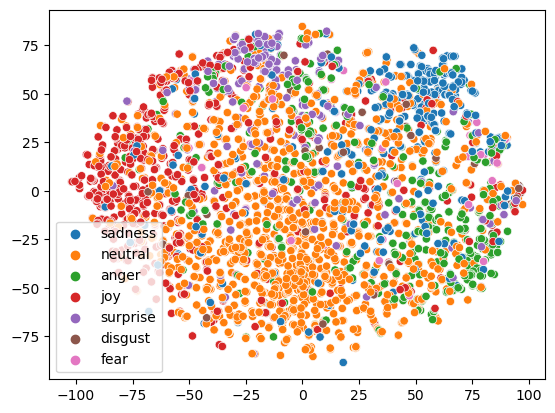

Epoch: 4 - Train Loss: 4.705932945605145


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.12s/it]


General - KNN F1: 0.6082219117168203 Acc: 0.6050376525577772
Iemocap - KNN F1: 0.704585656521737 Acc: 0.6946011281224819
Meld - KNN F1: 0.5660254369635919 Acc: 0.5624521072796935
Iemocap - KNN F1 (macro): 0.4661259989651838
Meld - KNN F1 (macro): 0.4059653139645043


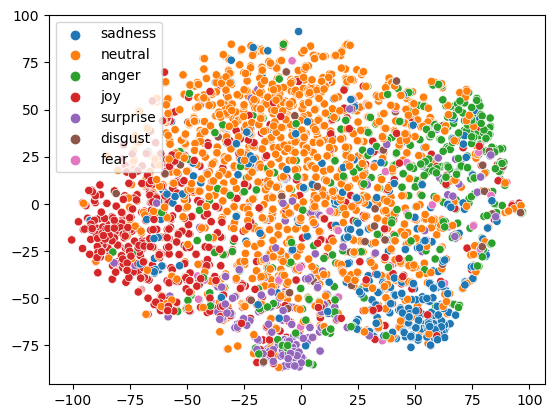

Epoch: 5 - Train Loss: 4.615149527985529


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


General - KNN F1: 0.6027470433943868 Acc: 0.5980264866268502
Iemocap - KNN F1: 0.6970263228123379 Acc: 0.6881547139403706
Meld - KNN F1: 0.5608031757934786 Acc: 0.5551724137931034
Iemocap - KNN F1 (macro): 0.39563641077990336
Meld - KNN F1 (macro): 0.39591915265816885


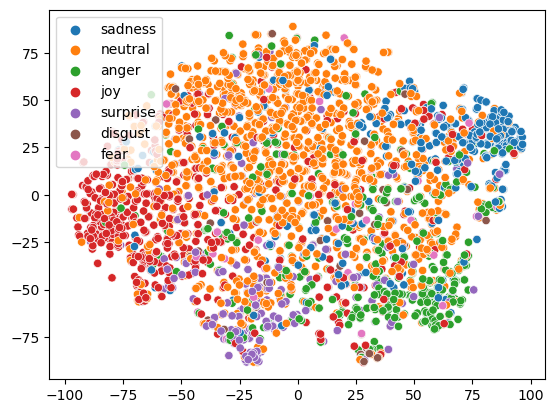

Epoch: 6 - Train Loss: 4.536275154707448


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


General - KNN F1: 0.6146816451059726 Acc: 0.6130875097377304
Iemocap - KNN F1: 0.7078155418819942 Acc: 0.7002417405318292
Meld - KNN F1: 0.5731339968115278 Acc: 0.571647509578544
Iemocap - KNN F1 (macro): 0.4015281076293949
Meld - KNN F1 (macro): 0.4090529944353453


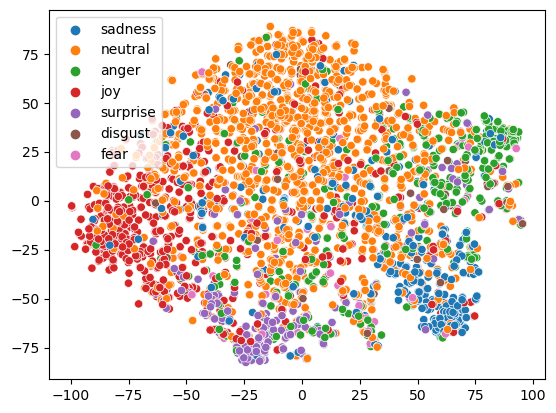

Epoch: 7 - Train Loss: 4.471771132867068


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]


General - KNN F1: 0.6081545563628723 Acc: 0.6065956894313166
Iemocap - KNN F1: 0.7061815550335321 Acc: 0.6954069298952458
Meld - KNN F1: 0.5637779464290603 Acc: 0.5643678160919541
Iemocap - KNN F1 (macro): 0.3996012785726771
Meld - KNN F1 (macro): 0.41091581256170795


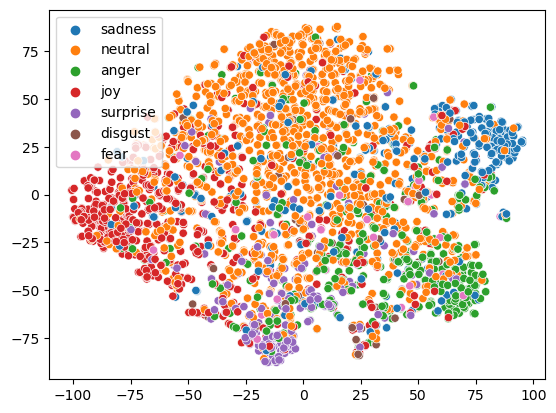

Epoch: 8 - Train Loss: 4.4080007928886165


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]


General - KNN F1: 0.6219289611653572 Acc: 0.6239937678525058
Iemocap - KNN F1: 0.7155399581623734 Acc: 0.7066881547139404
Meld - KNN F1: 0.5785777137466551 Acc: 0.5846743295019157
Iemocap - KNN F1 (macro): 0.4726075199289723
Meld - KNN F1 (macro): 0.4088628241665494


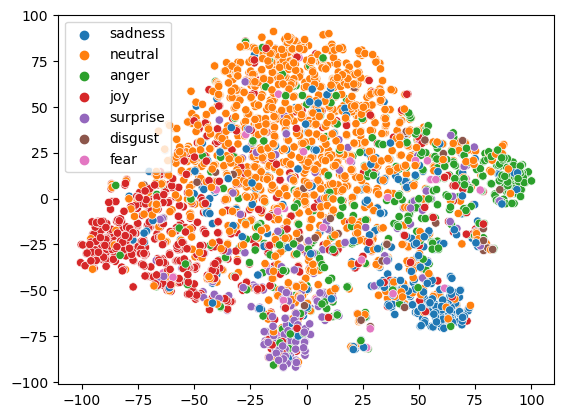

Epoch: 9 - Train Loss: 4.34975128931715


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]


General - KNN F1: 0.6216052811788666 Acc: 0.6237340950402492
Iemocap - KNN F1: 0.7117753273821464 Acc: 0.7010475423045931
Meld - KNN F1: 0.5804658356122075 Acc: 0.5869731800766284
Iemocap - KNN F1 (macro): 0.47525792041637
Meld - KNN F1 (macro): 0.4096544511361249


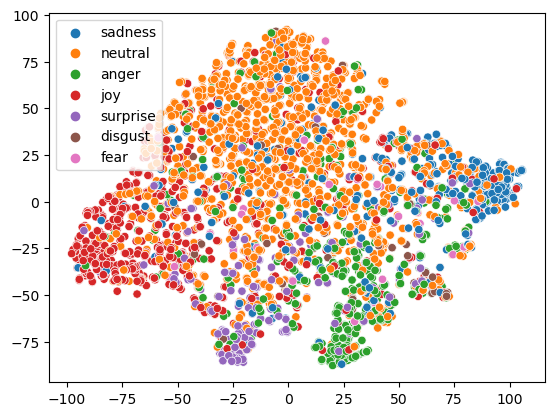

Epoch: 10 - Train Loss: 4.302448350072696


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]


General - KNN F1: 0.621007667079021 Acc: 0.625032459101532
Iemocap - KNN F1: 0.7060525037451579 Acc: 0.693795326349718
Meld - KNN F1: 0.5843256422809819 Acc: 0.5923371647509579
Iemocap - KNN F1 (macro): 0.405704661145574
Meld - KNN F1 (macro): 0.4101956694142007


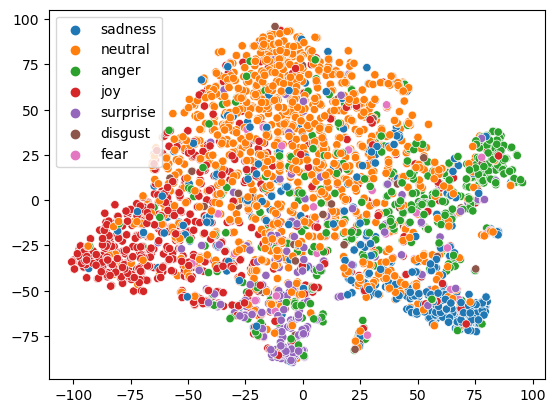

Epoch: 11 - Train Loss: 4.2504537926604415


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


General - KNN F1: 0.6145993526568347 Acc: 0.6182809659828616
Iemocap - KNN F1: 0.7058811164132681 Acc: 0.6962127316680097
Meld - KNN F1: 0.5727007621376804 Acc: 0.5812260536398467
Iemocap - KNN F1 (macro): 0.4019158494756363
Meld - KNN F1 (macro): 0.407812545534055


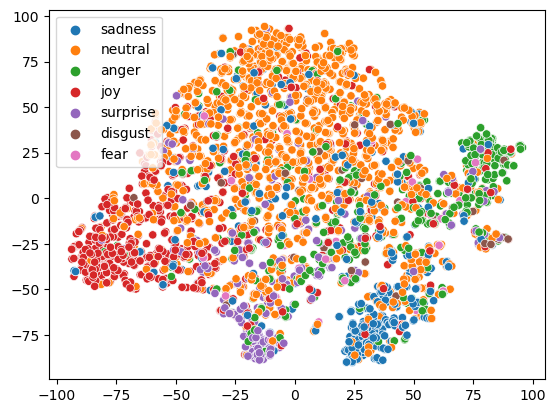

Epoch: 12 - Train Loss: 4.202626923062154


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


General - KNN F1: 0.6110619285924047 Acc: 0.615684237860296
Iemocap - KNN F1: 0.6843125041151528 Acc: 0.6768734891216761
Meld - KNN F1: 0.5774750090517358 Acc: 0.5865900383141762
Iemocap - KNN F1 (macro): 0.46200125230804895
Meld - KNN F1 (macro): 0.4124731479204961


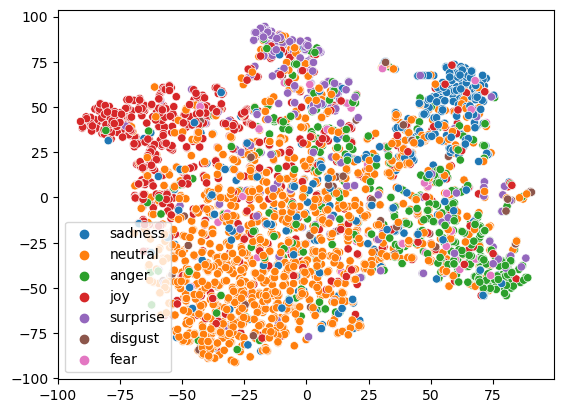

Epoch: 13 - Train Loss: 4.162576001211508


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


General - KNN F1: 0.6291859054767787 Acc: 0.6343806803427681
Iemocap - KNN F1: 0.7297202113086491 Acc: 0.7195809830781628
Meld - KNN F1: 0.5826601211866294 Acc: 0.5938697318007663
Iemocap - KNN F1 (macro): 0.4852577614076025
Meld - KNN F1 (macro): 0.41190530661971153


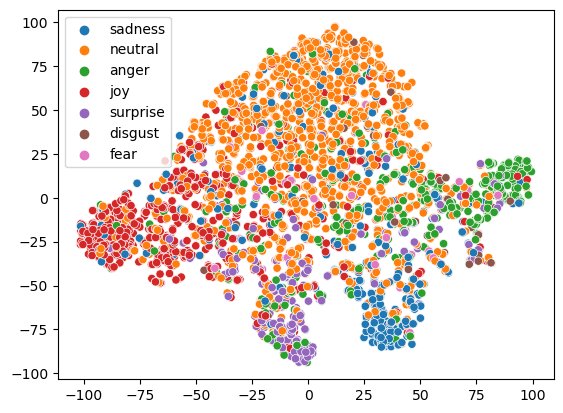

Epoch: 14 - Train Loss: 4.1251745018738


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


General - KNN F1: 0.6211178415586991 Acc: 0.6252921319137886
Iemocap - KNN F1: 0.6974739770823579 Acc: 0.6881547139403706
Meld - KNN F1: 0.5872335619136115 Acc: 0.5954022988505747
Iemocap - KNN F1 (macro): 0.4680506595780791
Meld - KNN F1 (macro): 0.4176420515823115


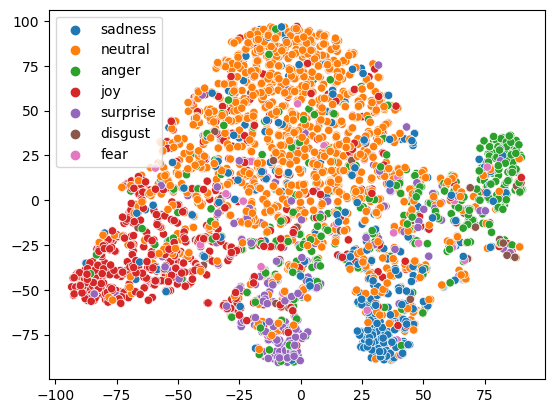

Epoch: 15 - Train Loss: 4.093723101331698


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]


General - KNN F1: 0.6266515833928815 Acc: 0.6349000259672812
Iemocap - KNN F1: 0.7150789019598406 Acc: 0.7058823529411765
Meld - KNN F1: 0.5854757117565342 Acc: 0.6011494252873564
Iemocap - KNN F1 (macro): 0.4096966838582559
Meld - KNN F1 (macro): 0.40510823122402145


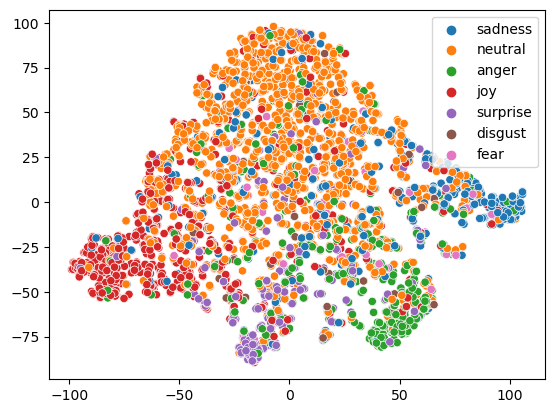

Epoch: 16 - Train Loss: 4.069700473191722


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it]


General - KNN F1: 0.6153371559896538 Acc: 0.624513113477019
Iemocap - KNN F1: 0.6936789768424813 Acc: 0.6825141015310233
Meld - KNN F1: 0.580527121584458 Acc: 0.5969348659003831
Iemocap - KNN F1 (macro): 0.4678027878206537
Meld - KNN F1 (macro): 0.40090421346926813


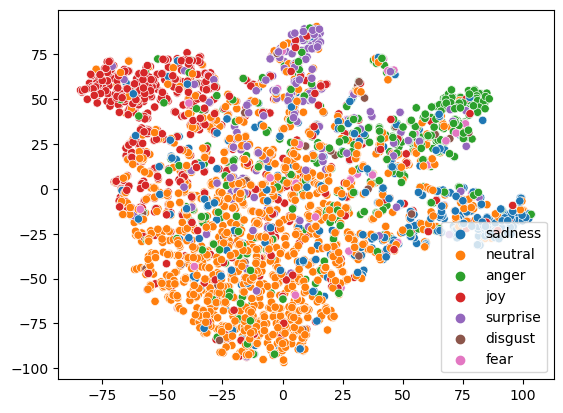

Epoch: 17 - Train Loss: 4.049040439902552


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]


General - KNN F1: 0.6209486752570277 Acc: 0.6281485328486107
Iemocap - KNN F1: 0.7104486861486812 Acc: 0.6994359387590653
Meld - KNN F1: 0.5814641937753745 Acc: 0.5942528735632184
Iemocap - KNN F1 (macro): 0.4075238658522931
Meld - KNN F1 (macro): 0.40096893472426487


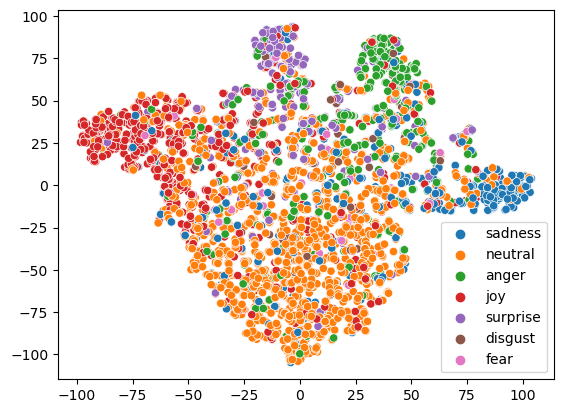

Epoch: 18 - Train Loss: 4.032854633615506


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]


General - KNN F1: 0.6180685684098595 Acc: 0.6229550766034796
Iemocap - KNN F1: 0.7173933383467707 Acc: 0.7107171635777598
Meld - KNN F1: 0.573079077514396 Acc: 0.5812260536398467
Iemocap - KNN F1 (macro): 0.4774670471227016
Meld - KNN F1 (macro): 0.40953622837839515


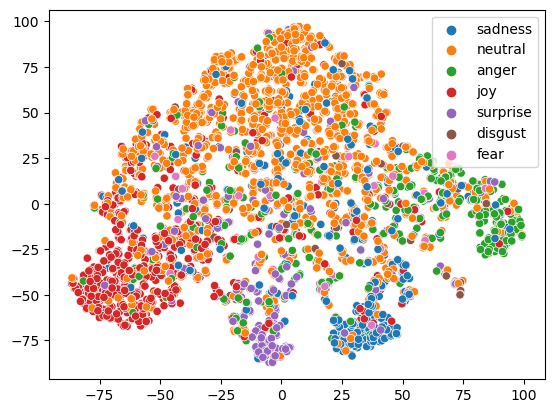

Epoch: 19 - Train Loss: 4.012868042813231


  4%|█▌                                        | 11/302 [00:09<04:12,  1.15it/s]


KeyboardInterrupt: 

In [53]:
if pre_train_text:
    train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=300, shuffle=True)

    test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

    MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
    text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFRS]', '[BFRE]', '[AFTS]', '[AFTE]'])

    PATH_TO_SAVE = f'text_encoder_pre_trained_utt_level_{MODEL_NAME}'
    !mkdir -p {PATH_TO_SAVE}
    supcon_model = AudioTextContrastive(
        text_encoder,
        None,
        in_features_text=768,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )

    # Grid search best temperatures
    # Try to only fine tune on evaluation datasets
    #supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

    supcon_model.to(0)

    scaler = torch.cuda.amp.GradScaler()

    step = 0
    e = 0
    patience = 9999
    early_stop_flag = 0
    old_f1 = -float('inf')

    param_optimizer = list(supcon_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.1
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

    scheduler_epochs = 5
    opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, betas=(0.9, 0.98), eps=1e-8)
    scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
    #scheduler = Scheduler(opt, 768, 600)

    epochs = 9999

    while e < epochs:
        supcon_model.train()
        epoch_loss = 0.0
        proj_val = []
        targets_val = []

        proj_train = []
        targets_train = []

        for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
            if i == len(train_loader)-1:
                continue
            batch = df_train.iloc[batch_indices[0]]
            batch = batch[~batch["text"].isna()].reset_index(drop=True)

            batch_lab_idx = batch[batch["label"].notna()].index
            sentences = batch["text"].tolist()

            y_text = torch.Tensor(lab_encoder.transform(batch.iloc[batch_lab_idx]["label"]))
            y_text_senti = torch.Tensor(lab_encoder_senti.transform(batch["sentiment_label"]))

            # Augment Text Context
            #for i_s, s in enumerate(sentences):
            #    if "[CTXE]" in s.split(' '):
            #        if np.random.rand() < 0.5:
            #            sentences[i_s] = sentences[i_s].split("[CTXE]")[1]
            """
            for k, s in enumerate(sentences):
                if '[BFR]' not in s and '[AFT]' not in s:
                    continue
                if '[BFR]' in s:
                    sentences[k] = sentences[k].split('[BFR]')[1]
                if '[AFT]' in s:
                    sentences[k] = sentences[k].split('[AFT]')[0]
            """
            target = y_text.long().cuda()
            target_senti = y_text_senti.long().cuda()

            x = [sentences, None, None]

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

                out = supcon_model(x)

                # Multimodal loss
                out_x = out["x_text"]
                out_x_lab = out_x[batch_lab_idx]
                out_x_wide = out["x_text_wide"][batch_lab_idx]

                loss = 0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            scaler.step(opt)
            scaler.update()
            #scheduler.step()

            opt.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
            proj_train.append(np.array(out_x_wide.detach().cpu()))
            targets_train.append(np.array(target.cpu()))

            del out_x
            del out
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

        scheduler.step()
        proj_train = np.concatenate(proj_train, axis=0)
        targets_train = np.concatenate(targets_train, axis=0)

        clf = FaissKNeighbors(k=128)
        clf.fit(proj_train, np.array(targets_train, dtype=int))

        epoch_loss = epoch_loss/len(train_loader)
        #supcon_model.eval()
        preds = []
        targets = []
        css = 0.0
        wide_audio = []

        for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
            with torch.no_grad():

                multimodal_batch = test_df_erc.iloc[batch_indices[0]]

                sentences = [str(t['text']) for _, t in multimodal_batch.iterrows()]

                target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))
                """
                for k, s in enumerate(sentences):
                    if '[BFR]' not in s and '[AFT]' not in s:
                        continue
                    if '[BFR]' in s:
                        sentences[k] = sentences[k].split('[BFR]')[1]
                    if '[AFT]' in s:
                        sentences[k] = sentences[k].split('[AFT]')[0]
                
                """
                x = [sentences, None, None]
                with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                    out = supcon_model(x)

                # Multimodal loss
                out_x_wide = out["x_text_wide"]

                wide = np.array(out_x_wide.cpu())
                pred = clf.predict(wide)
                preds.append(pred)

                assert len(wide) == len(pred)

                proj_val.append(wide)
                targets_val.append(np.array(target.cpu()))
                del out_x_wide
                gc.collect()
                torch.cuda.empty_cache()

        proj_val = np.concatenate(proj_val, axis=0)
        targets_val = np.concatenate(targets_val, axis=0)

        preds = np.array(np.concatenate(preds, axis=0))

        general_f1 = f1_score(targets_val, preds, average='weighted')
        general_acc = accuracy_score(targets_val, preds)

        meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
        iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

        general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
        general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

        general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
        general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

        print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        try:
            tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

            sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
            plt.show()

        except:
            pass

        print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
        e += 1

        #if e == scheduler_epochs: # Unfreeze text encoder
        #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
        #        param.requires_grad = True

        with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
            f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
            f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
            f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
if pre_train_text:
    supcon_model = AudioTextContrastive(
        text_encoder,
        None,
        in_features_text=768,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.2,
    )
    supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])
    torch.save(supcon_model.text_encoder.state_dict(), f'{PATH_TO_SAVE}/dabest_text_encoder.bin')


## Audio PreTrain

In [ ]:
gc.collect()

In [ ]:
if pre_train_audio:
    train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train[df_train["path"].notna()])))))
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

    test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

    PATH_TO_SAVE = 'audio_encoder_pre_trained_5_layer_2'
    !mkdir -p {PATH_TO_SAVE}
    supcon_model = AudioTextContrastive(
        None,
        audio_encoder,
        in_features_text=384,
        in_features_audio=dim_embed, 
        hidden_size=384,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )

    # Grid search best temperatures
    # Try to only fine tune on evaluation datasets

    supcon_model.to(0)

    scaler = torch.cuda.amp.GradScaler()

    step = 0
    e = 0
    patience = 9999
    early_stop_flag = 0
    old_f1 = -float('inf')

    param_optimizer = list(supcon_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.1
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

    scheduler_epochs = 5
    opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)
    #scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
    scheduler = Scheduler(opt, dim_embed, 600)
    #for i in range(24 * 146):
    #    scheduler.step()
    
    #checkpoint = {"model": supcon_model.state_dict(),
    #          "optimizer": opt.state_dict(),
    #          "scaler": scaler.state_dict()}
    #supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['model'])
    #opt.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['optimizer'])
    #scaler.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['scaler'])
    
    epochs = 9999

    while e < epochs:
        supcon_model.train()
        epoch_loss = 0.0
        proj_val = []
        targets_val = []

        proj_train = []
        targets_train = []

        for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
            if i == len(train_loader)-1:
                continue
            batch = df_train[df_train["path"].notna()].reset_index(drop=True).iloc[batch_indices[0]]
            
            only_audio = batch[batch["path"].notna()].reset_index(drop=True)
            only_audio_lab_idx = only_audio[only_audio["label"].notna()].index
            
            audio_paths = only_audio["path"].tolist()
            
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.float().to(0),
                "attn_masks": att.float().to(0),
            }

            y_audio = torch.Tensor(lab_encoder.transform(only_audio.iloc[only_audio_lab_idx]["label"]))
            y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))

            target = y_audio.long().cuda()
            target_senti = y_audio_senti.long().cuda()

            x = [None, audio_input, None]

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

                out = supcon_model(x)

                # Multimodal loss
                out_x = out["x_audio"]
                out_x_lab = out_x[only_audio_lab_idx]
                out_x_wide = out["x_audio_wide"][only_audio_lab_idx]

                loss = 0.7 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) + 0.1 * out["vq_loss"]

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            scaler.step(opt)
            scaler.update()
            scheduler.step()

            opt.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
            proj_train.append(np.array(out_x_wide.detach().cpu()))
            targets_train.append(np.array(target.cpu()))

            del out_x
            del out
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()
            
        proj_train = np.concatenate(proj_train, axis=0)
        targets_train = np.concatenate(targets_train, axis=0)

        clf = FaissKNeighbors(k=128)
        clf.fit(proj_train, np.array(targets_train, dtype=int))

        epoch_loss = epoch_loss/len(train_loader)
        #supcon_model.eval()
        preds = []
        targets = []

        for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
            with torch.no_grad():

                multimodal_batch = test_df_erc.iloc[batch_indices[0]]

                audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
                mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

                audio_input = {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}

                target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

                x = [None, audio_input, None]
                with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                    out = supcon_model(x)

                # Multimodal loss
                out_x_wide = out["x_audio_wide"]

                wide = np.array(out_x_wide.cpu())
                pred = clf.predict(wide)
                preds.append(pred)

                assert len(wide) == len(pred)

                proj_val.append(wide)
                targets_val.append(np.array(target.cpu()))
                del out_x_wide
                del out
                gc.collect()
                torch.cuda.empty_cache()

        proj_val = np.concatenate(proj_val, axis=0)
        targets_val = np.concatenate(targets_val, axis=0)

        preds = np.array(np.concatenate(preds, axis=0))

        general_f1 = f1_score(targets_val, preds, average='weighted')
        general_acc = accuracy_score(targets_val, preds)

        meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
        iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

        general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
        general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

        general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
        general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

        print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        try:
            tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

            sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
            plt.show()

        except:
            pass

        print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
        e += 1

        #if e == scheduler_epochs: # Unfreeze text encoder
        #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
        #        param.requires_grad = True

        with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
            f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
            f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
            f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
if pre_train_audio:
    supcon_model = AudioTextContrastive(
        None,
        audio_encoder,
        in_features_text=384,
        in_features_audio=dim_embed, 
        hidden_size=384,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )
    supcon_model.load_state_dict(torch.load(f'audio_encoder_pre_trained_5_layer_2/pytorch_model_AudioTextCLIP_epoch_55.bin')['model'])
    torch.save(supcon_model.audio_encoder.state_dict(), f'audio_encoder_pre_trained_5_layer_2/dabest_text_encoder.bin')

In [ ]:
pre_train_audio

In [ ]:
dim_embed = 768
N_VECTORS = 512
MAX_LEN = 256

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=1, 
    max_length=MAX_LEN, 
    nheads=12,
    dropout=0.1
)
audio_encoder.load_state_dict(torch.load(f'audio_encoder_pre_trained_1_layer/dabest_text_encoder.bin'))

In [ ]:
MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]'])
text_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_sentence-transformers/all-mpnet-base-v2/dabest_text_encoder.bin'))

In [ ]:
for param in text_encoder.parameters():
    param.requires_grad = False
for param in text_encoder.encoder.encoder.layer[11].parameters():
    param.requires_grad = True
for param in text_encoder.encoder.pooler.parameters():
    param.requires_grad = True
for param in audio_encoder.parameters():
    param.requires_grad = True

In [ ]:
#sentences_mult

In [ ]:
#list(weights.cpu().numpy())

In [ ]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_13'
!mkdir -p {PATH_TO_SAVE}
supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    rate=0.2,
)

# Grid search best temperatures
# Try to only fine tune on evaluation datasets
#supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

supcon_model.to(0)

scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

scheduler_epochs = 5
opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5, betas=(0.9, 0.98), eps=1e-8)
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.8, total_iters=10, last_epoch=- 1, verbose=False)
#scheduler = Scheduler(opt, 768, 600)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        batch = df_train.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))
        y_text_senti = torch.Tensor(lab_encoder_senti.transform(only_text["sentiment_label"]))
        
        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()

        mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

        audio_input = {
            "features": mfccs.float().to(0),
            "attn_masks": att.float().to(0),
        }

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))
        y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))
        
        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()].reset_index(drop=True)
        
        mult_not_na_idx = mult[mult["label"].notna()].index
        #batch_not_na_idx = batch[batch["label"].notna()].index
        #mult_na_idx = mult[mult["label"].isna()].index
        
        y_mult = torch.Tensor(lab_encoder.transform(mult.iloc[mult_not_na_idx]["label"]))
        
        y_mult_senti = torch.Tensor(lab_encoder_senti.transform(mult["sentiment_label"]))
        
        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]
        
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)
        
        # Augment Text Context
        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]
        
        for k, s in enumerate(sentences_mult):
            if '[BFR]' not in s and '[AFT]' not in s:
                continue
            if '[BFR]' in s:
                sentences_mult[k] = sentences_mult[k].split('[BFR]')[1]
            if '[AFT]' in s:
                sentences_mult[k] = sentences_mult[k].split('[AFT]')[0]
                        
        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}
        
        target = torch.cat([y_text, y_audio, y_mult]).long().cuda()
        target_senti = torch.cat([y_text_senti, y_audio_senti, y_mult_senti]).long().cuda()
        
        x = [sentences, audio_input, multimodal]
        
        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult_text_norm = F.normalize(x_mult_text, dim=-1)
                x_mult_audio_norm = F.normalize(x_mult_audio, dim=-1)
                
                #weights = torch.stack([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                weights = torch.cat([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                #weights = torch.ones_like(weights)
                
                # Augument modality
                augs = random.choices(
                    population=[0, 1, 2],
                    weights=[0.8, 0.1, 0.1],
                    k=len(x_mult_text)
                )
                
                x_mult = torch.stack([F.normalize(x_mult_text + x_mult_audio, dim=-1), 
                                      x_mult_text_norm, 
                                     x_mult_audio_norm], dim=1)
                
                x_mult = x_mult[list(range(len(augs))), augs, :] 
                
                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
                
                # Add weighted contrastive loss
                #x_mult_text = x_mult_text_norm.unsqueeze(dim=1)
                #x_mult_audio = x_mult_audio_norm.unsqueeze(dim=1)
                #mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                out_x, out_x_wide = None, None
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                elif x[1] is not None:
                    out_x = torch.cat([out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                    out_x_lab = torch.cat([out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                    out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                else:
                    out_x = x_mult.unsqueeze(dim=1)
                    out_x_lab = x_mult[mult_not_na_idx] #.unsqueeze(dim=1)
                    out_x_wide = x_mult_wide[mult_not_na_idx]
                
                # fera ta
                
                loss = 0.5 * (0.5 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.5 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)) \
                        + 0.5 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.2, weights=None)
                #loss = 0.5 * (0.5 * supcon_loss(out_x_lab, labels=target) + 0.5 * supcon_loss_senti(out_x, labels=target_senti)) + 0.5 * supcon_loss_intra(mult, weights=weights) 
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = 0.9 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.1 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) #+ 0.8 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.8, weights=None)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 30.0)
        scaler.step(opt)
        scaler.update()
        #scheduler.step()
        
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del x_mult
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()
    scheduler.step()
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    #supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    wide_audio = []
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_batch = test_df_erc.iloc[batch_indices[0]]

            audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
            mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

            sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

            for k, s in enumerate(sentences_mult):
                if '[BFR]' not in s and '[AFT]' not in s:
                    continue
                if '[BFR]' in s:
                    sentences_mult[k] = sentences_mult[k].split('[BFR]')[1]
                if '[AFT]' in s:
                    sentences_mult[k] = sentences_mult[k].split('[AFT]')[0]
                
            multimodal = {'sentences': sentences_mult, 
                          'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

            target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(F.normalize(out["x_mult_text_wide"], dim=-1), F.normalize(out["x_mult_audio_wide"], dim=-1))

            wide = np.array(out_x_wide.cpu())
            wide_audio.append(np.array(F.normalize(out["x_mult_audio_wide"], dim=-1).cpu()))
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    wide_audio = np.concatenate(wide_audio, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(test_df_erc)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    print(f'Cosine Similarity between mods: {css}')
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_f1_iemocap_audio = f1_score(targets_val[iemocap_idx], clf.predict(wide_audio)[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_f1_meld_audio = f1_score(targets_val[meld_idx], clf.predict(wide_audio)[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    print(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

    try:
        tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
        plt.show()
    
    except:
        pass
    
    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1
    
    #if e == scheduler_epochs: # Unfreeze text encoder
    #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
    #        param.requires_grad = True

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
        f.write(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
list(weights.cpu().numpy())[8]

In [ ]:
sentences_mult[:8]

In [ ]:
len(multimodal["sentences"])

In [ ]:
sentences

In [ ]:
mult.head(20)["text"].tolist()

In [ ]:
"""
Cosine Similarity between mods: 0.6148036817116292
General - KNN F1: 0.652949920693673 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7621117618450867 Acc: 0.7558420628525383
Iemocap - KNN F1 - Only Audio: 0.48286032752145575
Meld - KNN F1: 0.6025222678926638 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6085758686292261
Meld - KNN F1 (macro): 0.41899567212117655

Epoch: 31 - Train Loss: 6.175596459077136
"""

## Eval

In [ ]:
ss

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [ ]:
gc.collect()

In [ ]:
#PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_5_layer_pivoting_to_speech_training'

In [ ]:
#torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model']
#torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_1.bin')['model']

In [ ]:
PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    rate=0.0,
).cuda()
supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_15.bin')['model'])

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_n_params(supcon_model)

In [ ]:
supcon_model.eval()

In [ ]:
import pickle

In [ ]:
supcon_model.train()
test = supcon_model([["I Hate you, i believe you are shit!", "You are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I love you, mate!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
supcon_model.train()
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.100.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I am very sad"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
torch.norm(test["x_text"][0, :])

In [ ]:
torch.norm(test["x_audio"][0, :])

In [ ]:
supcon_model.train()
supcon_model.training = False
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.101.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I love my girlfriend, but she died"],audio_input, None])
    print(torch.dot(test["x_text"][0, :], test["x_audio"][0, :]))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I am sad"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["My dog was great, but he was also cute! Today he is dead"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=-1), F.normalize(test["x_audio"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I had a discussion with my mother", "I love my mother"],audio_input, None])
    print(torch.dot(test["x_text_wide"][0, :], test["x_audio_wide"][0, :]))
    print(torch.dot(test["x_text_wide"][1, :], test["x_audio_wide"][0, :]))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I just finished my PhD!!", "I finished my PhD, but I dont have a job"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_text_wide"][1, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.279.wav", "./audio/audio_emo/tess.woman.sad.59.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I did not pass in the final exam, i will kill myself"], audio_input, None])
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][1, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][1, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))

In [ ]:
test

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        activation[name] = output #.detach()
    return hook

In [ ]:
get_activation

In [ ]:
supcon_model

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        print(output.shape)
        activation[name] = output #.detach()
    return hook

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=False,
    rate=0.2,
).cuda()

supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_16.bin')['model'])

supcon_model.audio_proj.register_forward_hook(get_activation('audio_proj'))
output = supcon_model([["I had a discussion with my mother"],audio_input, None])
activation['audio_proj']

In [ ]:
m

In [ ]:
test["x_audio_wide"][0, :]

In [ ]:
test["x_audio"][0, :]

In [ ]:
test

In [ ]:
print(df_train[df_train["label"] == "sadness"]["path"].tolist())

In [ ]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [ ]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [ ]:
gc.collect()

In [ ]:
df_train_f =df_train

In [ ]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [ ]:
meld_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: True if "MELD" in x else False)].index

In [ ]:
iemocap_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: False if "MELD" in x else True)].index

In [ ]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[iemocap_train_idx].reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[meld_train_idx].reset_index(drop=True)
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_df_erc)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [ ]:
gc.collect()

In [ ]:
batch

In [ ]:
supcon_model.train()

proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
    with torch.no_grad():
        batch = train_df_erc.iloc[batch_indices[0]]

        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()]
        mult = mult[mult["label"].notna()]
        y_mult = torch.Tensor(lab_encoder.transform(mult["label"]))

        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]

        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

        target = y_mult

        x = [None, None, multimodal]

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #x_mult_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        proj_train.append(np.array(x_mult_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del x_mult_wide
        gc.collect()
        torch.cuda.empty_cache()
proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)

clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))

preds = []
targets = []
css = 0.0

for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_batch = test_df_erc.iloc[batch_indices[0]]

        audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

        target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #out_x_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)

preds = np.array(np.concatenate(preds, axis=0))

css = css / len(test_df_erc)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')

meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
plt.show()

In [ ]:
train_iemocap

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[meld_train_idx].mean(axis=0)
std_test = proj_train[meld_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[meld_train_idx]-mean_test)/std_test, np.array(targets_train[meld_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

from sklearn.metrics import classification_report

print(classification_report(targets_val[meld_idx], preds[meld_idx], digits=4))

In [ ]:
len(targets_val[iemocap_idx])

In [ ]:
set(lab_encoder.inverse_transform(np.array(targets_val[iemocap_idx], dtype=int)))


In [ ]:
df_iemocap_orig = pd.read_json("emotions.json").reset_index(drop=False)
df_iemocap_orig = pd.melt(df_iemocap_orig, id_vars=['index'], value_vars=['train', 'val', 'test']).dropna().drop(columns=["variable"]).rename(columns={"index":"id", "value": "orig_label"}).reset_index(drop=True)
df_iemocap_orig = df_iemocap_orig[df_iemocap_orig["orig_label"].notna() & (df_iemocap_orig["orig_label"] != "undecided")].reset_index(drop=True)
df_iemocap_orig

In [ ]:
def cleaning_shit(x):
    if "MELD" in x:
        return None
    x = x.replace("val/", "")
    x = x.replace("train/", "")
    x = x.replace("test/", "")
    l = len("/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/")
    return x[l:].replace(".wav", "")


In [ ]:
#train_df_erc_iemocap = train_df_erc[train_df_erc["path"].apply(lambda x: True if "IEMOCAP" in x else False)]
train_df_erc["id"] = train_df_erc["path"].apply(cleaning_shit)
train_df_erc_iemocap = train_df_erc.dropna()
train_df_erc_iemocap = train_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner").dropna()
train_df_erc_iemocap

In [ ]:
len(iemocap_train_idx)

In [ ]:
test_df_erc["id"] = test_df_erc["path"].apply(lambda x: x[len('/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/test/'):].replace(".wav", "")) 

In [ ]:
test_df_erc_iemocap = test_df_erc[test_df_erc["source"] == "iemocap"].reset_index(drop=True)
test_df_erc_iemocap

In [ ]:
test_df_erc_iemocap = test_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner")
test_df_erc_iemocap

In [ ]:
new_lab = LabelEncoder().fit(train_df_erc_iemocap["orig_label"])

In [ ]:
train_df_erc_iemocap["orig_label"].unique()

In [ ]:
test_df_erc_iemocap["orig_label"].unique()

In [ ]:
train_df_erc_iemocap

In [ ]:
test_df_erc_iemocap

In [ ]:
correct_labels_train = new_lab.transform(train_df_erc_iemocap["orig_label"])
correct_labels_test = new_lab.transform(test_df_erc_iemocap["orig_label"])

In [ ]:
correct_labels_train

In [ ]:
lab_encoder.classes_

In [ ]:
test_df_erc[test_df_erc["source"] == "iemocap"]["label"].value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train.mean(axis=0)
std_test = proj_train.std(axis=0)

#clf = MLPClassifier(hidden_layer_sizes=(768,), learning_rate="invscaling", solver="sgd", max_iter=5000, validation_fraction=0.2, nesterovs_momentum=False)
clf = LogisticRegression()
clf.fit((proj_train-mean_test)/std_test, np.array(targets_train, dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], preds[iemocap_idx], digits=4))

In [ ]:
general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])



In [ ]:
general_f1_iemocap

In [ ]:
general_f1_meld

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], list(map(lambda x: x if x != 1 else 6, preds[iemocap_idx])), digits=4))

## 